# RSNA Pnumonia Exploratory Data Analysis
Resource:
1. [Data](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)
2. [RSNA Pneumonia Detection EDA](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda)
3. [Exploratory Data Analysis](https://www.kaggle.com/peterchang77/exploratory-data-analysis)

In [51]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
import os
import pydicom
#%matplotlib inline 

In [3]:
PATH="./rsna-pneumonia-detection-challenge"
print(os.listdir(PATH))

['stage_2_sample_submission.csv', 'stage_2_train_images', 'GCP Credits Request Link - RSNA.txt', 'stage_2_detailed_class_info.csv', 'stage_2_train_labels.csv', 'stage_2_test_images']


In [38]:
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
sample_submission_df = pd.read_csv(PATH+'/stage_2_sample_submission.csv')

1. In class detailed info dataset are given the detailed information about the type of positive or negative class associated with a certain patient.
2. In train labels dataset are given the patient ID and the window (x min, y min, width and height of the) containing evidence of pneumonia.
3. What should I expect the data format to be?
    - The training data is provided as a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x-min y-min width height
    - There is also a binary target column, Target, indicating pneumonia or non-pneumonia.
    - There may be multiple rows per patientId.

In [35]:
print(f"row: {class_info_df.shape[0]}, column: {class_info_df.shape[1]}")
class_info_df.head()

row: 30227, column: 2


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [36]:
print(f"row: {train_labels_df.shape[0]}, column: {train_labels_df.shape[1]}")
train_labels_df.head()

row: 30227, column: 6


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [39]:
print(f"row: {sample_submission_df.shape[0]}, column: {sample_submission_df.shape[1]}")
sample_submission_df.head()

row: 3000, column: 2


,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


## Check missing data
It has been done by [RSNA Pneumonia Detection EDA](https://www.kaggle.com/gpreda/rsna-pneumonia-detection-eda), so I skip this step.

## Exploratory data

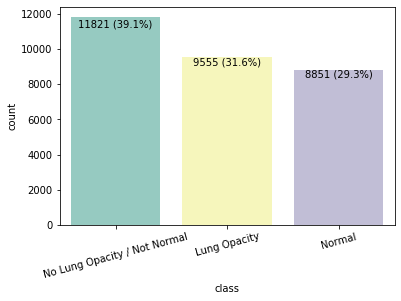

In [129]:
f, ax = plt.subplots(1,1, figsize=(6,4))
total = float(len(class_info_df))
sns.countplot(class_info_df['class'],order = class_info_df['class'].value_counts().index, palette='Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height-1/20*height,
            '{:1.0f} '.format(height) +'({:1.1f}%)'.format(100*height/total),
            ha="center") 
plt.xticks(rotation=15)
plt.show()

## Merge class info and label

In [41]:
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [42]:
print(f"row: {train_class_df.shape[0]}, column: {train_class_df.shape[1]}")
train_class_df.head()

row: 37629, column: 7


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [67]:
train_class_df.groupby('Target')['class'].value_counts()

Target  class                       
0       No Lung Opacity / Not Normal    11821
        Normal                           8851
1       Lung Opacity                    16957
Name: class, dtype: int64

In [80]:
train_class_df.groupby('class')['Target'].value_counts()

class                         Target
Lung Opacity                  1         16957
No Lung Opacity / Not Normal  0         11821
Normal                        0          8851
Name: Target, dtype: int64

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


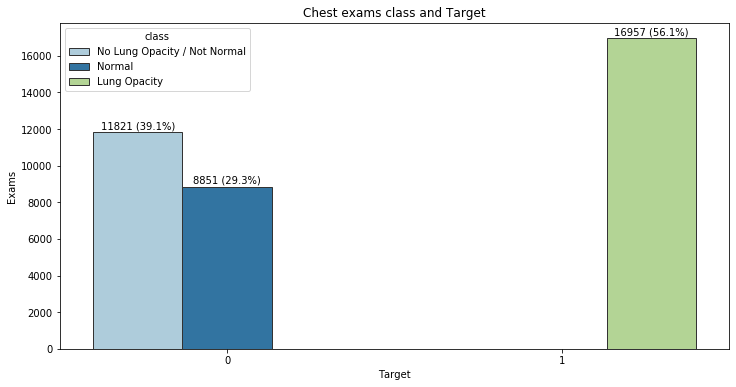

In [128]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_class_df.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='Exams',hue='class',data=df, palette="Paired", edgecolor=".2")
plt.title("Chest exams class and Target")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+200,
            '{:1.0f} '.format(height) +'({:1.1f}%)'.format(100*height/total),
            ha="center") 
plt.show()

In [45]:
len(train_class_df.patientId.unique())

26684

In [48]:
train_PATH=PATH+'/stage_2_train_images/'
train_PATH

'./rsna-pneumonia-detection-challenge/stage_2_train_images/'

In [49]:
len(os.listdir(train_PATH))

26684

In [53]:
dcm_file = train_PATH+'00436515-870c-4b36-a041-de91049b9ab4.dcm'
dcm_data = pydicom.read_file(dcm_file)
im = dcm_data.pixel_array

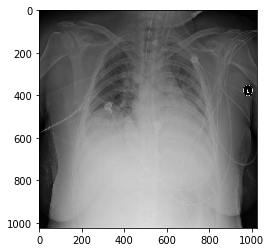

In [55]:
plt.imshow(im, cmap='gray')

In [95]:
# Forked from `https://www.kaggle.com/peterchang77/exploratory-data-analysis`
def parse_data(df):
    """
    Method to read a CSV file (Pandas dataframe) and parse the 
    data into the following nested dictionary:

      parsed = {
        
        'patientId-00': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        },
        'patientId-01': {
            'dicom': path/to/dicom/file,
            'label': either 0 or 1 for normal or pnuemonia, 
            'boxes': list of box(es)
        }, ...

      }

    """
    # --- Define lambda to extract coords in list [y, x, height, width]
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

parsed = parse_data(train_labels_df)

def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = pydicom.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb = [255, 251, 204] # Just use yellow
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=15)

    plt.imshow(im, cmap=plt.cm.gist_gray)
    plt.axis('off')

def overlay_box(im, box, rgb, stroke=2):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

In [96]:
parsed

{'0004cfab-14fd-4e49-80ba-63a80b6bddd6': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm',
  'label': 0,
  'boxes': []},
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c148ed3241cd.dcm',
  'label': 0,
  'boxes': []},
 '00322d4d-1c29-4943-afc9-b6754be640eb': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00322d4d-1c29-4943-afc9-b6754be640eb.dcm',
  'label': 0,
  'boxes': []},
 '003d8fa0-6bf1-40ed-b54c-ac657f8495c5': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm',
  'label': 0,
  'boxes': []},
 '00436515-870c-4b36-a041-de91049b9ab4': {'dicom': './rsna-pneumonia-detection-challenge/stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm',
  'label': 1,
  'boxes': [[152.0, 264.0, 379.0, 213.0], [152.0, 562.0, 453.0, 256.0]]},
 '00569f44-917d-4c86-a842-8

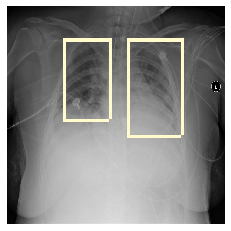

In [97]:
draw(parsed['00436515-870c-4b36-a041-de91049b9ab4'])

In [98]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/",patientImage)
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        data_row_img = dcm.dcmread(imagePath)
        ax[i//3, i%3].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = train_class_df[train_class_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()

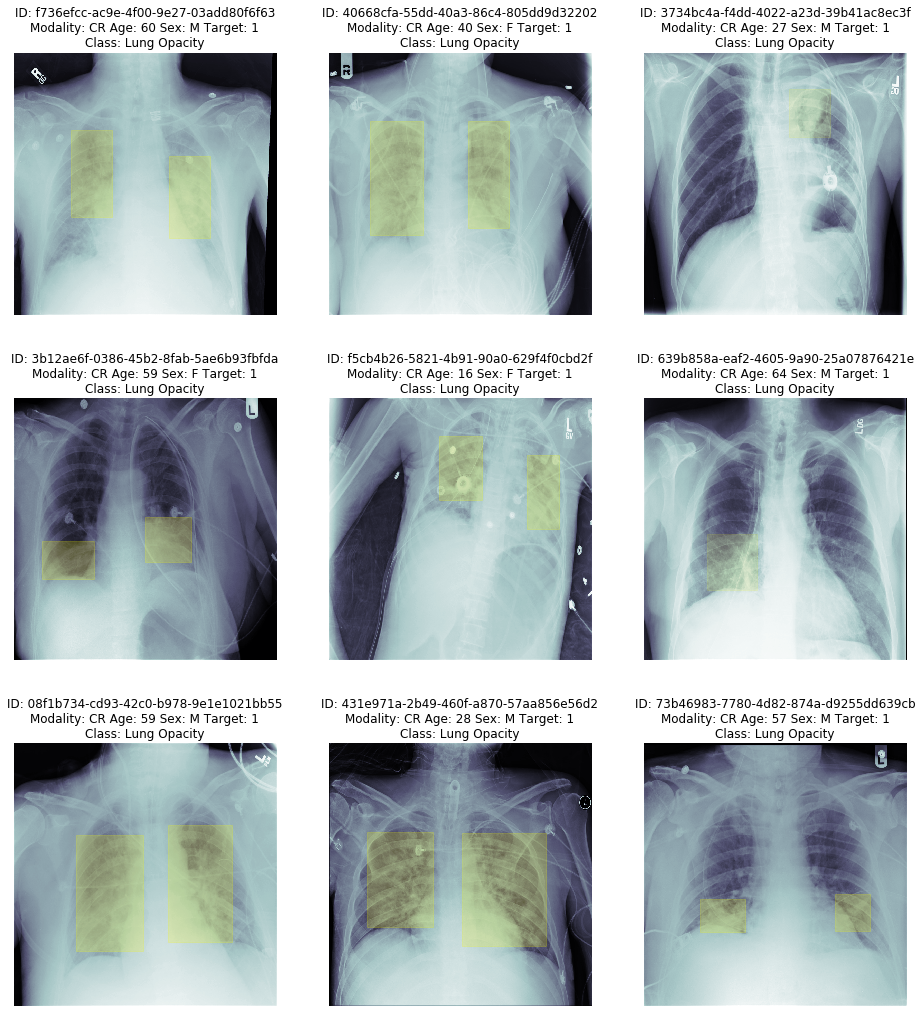

In [99]:
show_dicom_images_with_boxes(train_class_df[train_class_df['Target']==1].sample(9))